__Jupyter Lab Notebook (NB1) \#1: Data Wrangling__

__Objectives:__
* collecting instrument's unstructured cortisol measurements from 25 heterogeneous data files
* organizing the collected data
* making sure it's well defined
* preliminary data cleaning
* elucidation of target values
* engineering  potentially usesful features
* identification of fundamental issues with the data if present

__Contents__

* [1. Imports](#1)
* [2. Data ingestion](#2._Data_ingestion)
    * [2.1 Reviewing data files](#2.1)
    * [2.2 Normalization of csv-data](#2.2)
    * [2.3 Loading csv-data](#2.3)
    * [2.4 Loading xlsx-data](#2.4)
    * [2.5 Loading xls-data](#2.5)
    * [2.6 Graphical summary of all loaded records](#2.6)
* [3. Extraction of features and values](#3)
    * [3.1 csv-data](#3.1)
        * [3.1.1 Inspection of csv-data by interactive widgets](#3.1.1)
        * [3.1.2 A parser to process panel csv-data](#3.1.2)
        * [3.1.3 Processing the panel csv-data](#3.1.3)
        * [3.1.4 Cleaning the panel csv-data](#3.14)
    * [3.2 xlsx-data](#3.2)
        * [3.2.1 Inspection of xlsx-data by interactive widgets](#3.2.1)
        * [3.2.2 Separating time-series xlsx-data from panel xlsx-data](#3.2.2)
        * [3.2.3 Processing the panel xlsx-data by the panel csv-data parser](#3.2.3)
        * [3.2.4 Cleaning the panel xlsx-data](#3.24)
        * [3.2.5 A parser to process the time-series xlsx-data](#3.25)
        * [3.2.6 Processing the time-series xlsx-data](#3.2.6)
        * [3.2.7 Per-cell calibartion of population-wide time-series](#3.2.7)

# Imports<a id='1'></a>

In [26]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2021-07-21T21:06:59.855405-04:00

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.25.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.11.0-25-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit



In [27]:
import sys                             # Read system parameters
import os                              # Interact with the operating system

import math                            # Work with math functions
import numpy as np                     # Work with multi-dimensional arrays and matrices
import pandas as pd                    # Manipulate and analyze data
import datetime
import scipy as sp                     # Perform scientific computing and advanced mathematics

import matplotlib.pyplot as plt        # Create 2D charts
import seaborn as sns                  # Perform a nice data visualization

import re                              # support for regular expressions (RE)
import mailbox                         # mailbox - Read/write support for Maildir, mbox, MH, Babyl, and MMDF mailboxes
import csv                             # csv parsing and writing

import glob                            # Simplify reading data
from pathlib import Path

import ipywidgets as widgets 
from ipywidgets import interact, interact_manual

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import janitor
import pandas_flavor as pf

import more_itertools
import cmd; print_column_list = cmd.Cmd() # print lists in a nice form

#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
print('Report on the versions of the modules used:')
%matplotlib inline
%watermark --iversions

Report on the versions of the modules used:
plotly        : 5.1.0
pandas_flavor : 0.2.0
pandas        : 1.3.0
seaborn       : 0.11.1
csv           : 1.0
ipywidgets    : 7.6.3
janitor       : 0.20.14
scipy         : 1.7.0
more_itertools: 8.8.0
numpy         : 1.21.0
chart_studio  : 1.1.0
re            : 2.2.1
matplotlib    : 3.4.2
sys           : 3.9.5 (default, Jun  4 2021, 12:28:51) 
[GCC 7.5.0]



In [28]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Data ingestion<a id='2'></a>

We begin with basic understanding of all file types programmatically

## Reviewing data files<a id='2.1'></a>

In [29]:
PROJECT_ROOT_DIR = os.getcwd()
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")

path_csv = os.path.join(DATA_PATH, '*.csv')
list_csv = sorted(glob.glob(path_csv))

path_xlsx = os.path.join(DATA_PATH, '*.xlsx')
list_xlsx = sorted(glob.glob(path_xlsx))

path_xls = os.path.join(DATA_PATH, '*.xls')
list_xls = sorted(glob.glob(path_xls))

# Extract the current directory name
dir_name = path_csv[:path_csv.rfind('/')]

print('REPORT ON HETEROGENEOUS DATA FILES:')
print('Directory: {}'.format(dir_name))
print('Total files: {}'.format( len(list_csv) + len(list_xlsx) + len(list_xls)))
print('{}: {}'.format('csv', len(list_csv)))
print('{}: {}'.format('xlsx', len(list_xlsx)))
print('{}: {}'.format('xls', len(list_xls)))

print('\nLIST ALL FILES:')
fpath_lst = list_csv + list_xlsx + list_xls
fname_lst = [fpath[(path_csv.rfind('/')+1):] for fpath in fpath_lst]
print_column_list.columnize(fname_lst, displaywidth=80)

REPORT ON HETEROGENEOUS DATA FILES:
Directory: /home/evgeni/Dropbox/AFRL_Projects/CORTISOL/nb1_data_wrangling/data
Total files: 25
csv: 9
xlsx: 13
xls: 3

LIST ALL FILES:
2018-07-18_E-coli_E2-Crimson_Cortisol_Conc_Curve_2018_0718_SD.csv
2018-07-20_E-coli_RFP_Cortisol_Conc_Curve-Density-Culture_Conditions_2018_0720.csv
2018-09-13_Working_2_GFP_Yeast_Cortisol_THF_Conc_Curve_2018_0913.csv
2018-09-26_Ecoli_RFP_Cortisol_THF_Conc_Curve_2018_0926.csv
2018-09-26_Working_Ecoli_RFP_Cortisol_THF_Conc_Curve_2018_0926.csv
2018-10-16_Ecoli_RFP_Cortisol_THF_Conc_Curve_2018_1016.csv
2018-10-16_Working_Ecoli_RFP_Cortisol_THF_Conc_Curve_2018_1016.csv
2019-12-20_Ecoli_WT_pE2Crimson_Cortisol_Dose_Response_2019_1204.csv
2019-12-20_Ecoli_sfGFP_integrate_C11_Dose_Response_2019.csv
2019-08-19_1st_dataset_082819_pLysRsfGFP_IAI6_tolC_ApmR_2mM_Cort.xlsx
2019-09-10_pLysRsfGFP_and_Integrate_tolcLysR_E2_crimson.xlsx
2019-10-30_103019_Cort_vs_THF_in_pLysRsfGFP_EN1917_Apmr_in_tolC_mutant.xlsx
2019-11-20_112019_EN1917

## Normalization of csv-data<a id='2.2'></a>

Here, we normalize data from csv-files to have fixed columns compatible with the corresponding columns from xls- and xlsx-files, respectively.

In [30]:
def read_unstructured_csv(fpath):
    """
    FUNCTION: read_unstructured_csv transforms unstractured data into a strucutred pandas' DataFrame
    """
    ### Loop the data lines
    with open(fpath, 'r') as f:

        # get No of columns in each line
        col_count = [ len(line.split(",")) for line in f.readlines() ]

    ### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
    column_names = [i for i in range(0, max(col_count))]

    ### Read csv
    df = pd.read_csv(fpath, header=None, delimiter=",", names=column_names)
    
    return df

## Loading csv-data<a id='2.3'></a>

In [31]:
data_csv_dct = {}
csv_records = 0
print('REPORT ON RECORDS LOADED FROM {} FILES:'.format('*.csv'))
for f in list_csv:
    fname = f[f.rfind('/')+1 :]
    data_csv_dct[fname] = read_unstructured_csv(f)
    print('Loaded {} records from {}'.format(len(data_csv_dct[fname]), fname))
    csv_records += len(data_csv_dct[fname])

print('Loaded total files: {}'.format(len(list_csv)))
print('Loaded total records from all {} files: {}'.format('csv', csv_records))

fname_csv = list(data_csv_dct.keys())

REPORT ON RECORDS LOADED FROM *.csv FILES:
Loaded 228 records from 2018-07-18_E-coli_E2-Crimson_Cortisol_Conc_Curve_2018_0718_SD.csv
Loaded 720 records from 2018-07-20_E-coli_RFP_Cortisol_Conc_Curve-Density-Culture_Conditions_2018_0720.csv
Loaded 390 records from 2018-09-13_Working_2_GFP_Yeast_Cortisol_THF_Conc_Curve_2018_0913.csv
Loaded 443 records from 2018-09-26_Ecoli_RFP_Cortisol_THF_Conc_Curve_2018_0926.csv
Loaded 443 records from 2018-09-26_Working_Ecoli_RFP_Cortisol_THF_Conc_Curve_2018_0926.csv
Loaded 480 records from 2018-10-16_Ecoli_RFP_Cortisol_THF_Conc_Curve_2018_1016.csv
Loaded 519 records from 2018-10-16_Working_Ecoli_RFP_Cortisol_THF_Conc_Curve_2018_1016.csv
Loaded 584 records from 2019-12-20_Ecoli_WT_pE2Crimson_Cortisol_Dose_Response_2019_1204.csv
Loaded 749 records from 2019-12-20_Ecoli_sfGFP_integrate_C11_Dose_Response_2019.csv
Loaded total files: 9
Loaded total records from all csv files: 4556


## Loading xlsx-data<a id='2.4'></a>

In [32]:
data_xlsx_dct = {}
xlsx_records = 0
print('REPORT ON RECORDS LOADED FROM {}-FILES:'.format('xlsx'))
for f in list_xlsx:
    fname = f[f.rfind('/')+1 :]
    data_xlsx_dct[fname] = pd.read_excel( f,  header=None )
    print('Loaded {} records from {}'.format(len(data_xlsx_dct[fname]), fname))
    xlsx_records += len(data_xlsx_dct[fname])

print('Loaded total files: {}'.format(len(list_xlsx)))
print('Loaded total records from all {}-files: {}'.format('xlsx', xlsx_records))

fname_xlsx = list(data_xlsx_dct.keys())

REPORT ON RECORDS LOADED FROM xlsx-FILES:
Loaded 278 records from 2019-08-19_1st_dataset_082819_pLysRsfGFP_IAI6_tolC_ApmR_2mM_Cort.xlsx
Loaded 437 records from 2019-09-10_pLysRsfGFP_and_Integrate_tolcLysR_E2_crimson.xlsx
Loaded 260 records from 2019-10-30_103019_Cort_vs_THF_in_pLysRsfGFP_EN1917_Apmr_in_tolC_mutant.xlsx
Loaded 260 records from 2019-11-20_112019_EN1917_tolC_integrate_LysRsfGFP_2mM_Cortisol_against_negative_control.xlsx
Loaded 346 records from 2019-12-27_C11_vs_C11_with_pLysE2Crimson_Enhancement.xlsx
Loaded 261 records from 2019_10_30_Cort_vs_THF_in_pLysRsfGFP_EN1917_Apmr_in_tolC_mutant.xlsx
Loaded 279 records from 2019_10_31_1mM_Cortisol_vs_T1_negative.xlsx
Loaded 623 records from 2019_12_04_Ecoli_pE2Crimson_WT_Cortisol_Dose_Response_re-analysis.xlsx
Loaded 849 records from 2019_12_19_Ecoli_sfGFP_Integrate_C11_Dose_Response_reanalysis_v1.xlsx
Loaded 260 records from 2020-01-02_010220_2mM_cort_C11.xlsx
Loaded 260 records from 2020-01-07_010720_beta_glucuronide_vs_cort_1mM

In [33]:
data_xlsx_dct['2020-01-31_1mM_cort_vs_thf_e_coli_nissle_1917_sfGFP.xlsx'].head(20)

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,Experiment,Cort vs THF Neo2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cell,EcN1917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Genotype,MT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cortisol-THF-Neo2,1mM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Reporter,GFP_E2Crimson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Plasmid,pLysR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Software Version,3.08.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Experiment File Path:,C:\Users\VLitteral\Desktop\Biotek\Biotek 2019\...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Protocol File Path:,C:\Users\Public\Documents\Protocols\sfGFP and ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Loading xls-data<a id='2.5'></a>

In [34]:
data_xls_dct = {}
xls_records = 0
print('REPORT ON RECORDS LOADED FROM {}-FILES:'.format('xls'))
for f in list_xls:
    fname = f[f.rfind('/')+1 :]
    data_xls_dct[fname] = pd.read_excel( f, header=None )
    print('Loaded {} records from {}'.format(len(data_xls_dct[fname]), fname))
    xls_records += len(data_xls_dct[fname])

print('Loaded total files: {}'.format(len(list_xls)))
print('Loaded total records from all {}-files: {}'.format('xls', xls_records))

fname_xls = list(data_xls_dct.keys())

REPORT ON RECORDS LOADED FROM xls-FILES:
Loaded 289 records from 2019-11-14_111419vl_pLysRe2cr_EN1917_Wild_Type_2mM_Cort_vs_pLysTDC_2mM_cortisol.xls
Loaded 260 records from 2019_10_31_1mM_THF_vs_negative_T1.xls
Loaded 288 records from 2020-01-07_010720_plysre2cr_e3.xls
Loaded total files: 3
Loaded total records from all xls-files: 837


## Graphical summary of all loaded records<a id='2.6'></a>

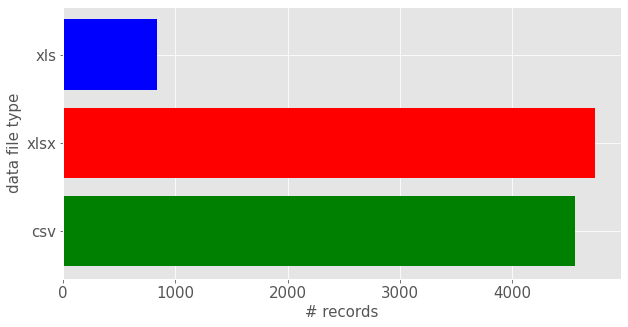

In [35]:
records_ori = pd.DataFrame({'x': ['csv', 'xlsx', 'xls'], 'y': [csv_records, xlsx_records, xls_records]})
plt.figure(figsize=(10, 5))
plt.barh('x', 'y', data=records_ori, color=['green', 'red', 'blue'])
plt.ylabel('data file type', fontsize=15)
plt.xlabel('# records', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# Extraction of features and values<a id='3_Extraction_of_features_and_values'></a>

## csv-data<a id='3.1'></a>

### Inspection of csv-data by interactive widgets<a id='3.1.1'></a>

In [36]:
@interact
def view_csv(fname=list(data_csv_dct.keys()), lines=60):
    display(data_csv_dct[fname].head(lines))

interactive(children=(Dropdown(description='fname', options=('2018-07-18_E-coli_E2-Crimson_Cortisol_Conc_Curve…

<div class="alert-info"><font color="black">

<strong style='color:red'>Based on the interactive data inspection (see above), we have come to the following features and their respective value types:</strong>    
    
* <strong style='color:red'>First of all, the *.csv-originated DataFrames do not inlcude time series but only panel data obtained at cross-section of $t \, =\, 4.5$ hr.</strong>

* <strong style='color:red'>Second, four most essential Features and their respective Values are:</strong>

    1. A buffered cortisol concentration (Value) in the medium used as a clamped external condition (Feature), which we treat mathematically as an _explanatory_ variable (_regressor_).

    2. Response (Feature) of cell culture to the cortisol dose in terms of fluorescent intensity (Value), which we treat mathematically as a _response_ variable.

    3. Cell culture name (Feature) with binary categorical Value: _E. coli_ (Procariote) versus _Yeast_ (Eucariote).

    4. Genotype name (Feature) with binary categorical Value: MT (mutation) versus WT (wild type without (WT) DNA mutation).

* <strong style='color:red'>Third, two less essential Features are:</strong>

    5. The name of each experiment with discrete categorical Value.

    6. The date and time of each experiment with datetime Value.

</font></div>  

<div class="alert-warning"><font color="black">
    
<strong style='color:red'>We develop and follow the following Feature-Value extraction production steps:</strong>    

* Based on the context and our biological expertise, we first identify some specific fields, which are found in the first column (with index 0) and which do not change between different files, as features.

* Similarly, we then identify specific fields present in the same row as the feature's values. Such values do not have fixed column indexes.
    
* Our feature extraction is based on the following observations:

    1. The first row with index 0 contains feature 'Experiment Name' in column 0 and its value in column 1, e.g. ('feature', 'value') = ('Experiment Name', 'E-coli E2-Crimson Cortisol Conc Curve 2018 0718')
    
    2. The above (feature,value)-pair can be split into two essential (feature, value) pairs, (i) ('Cell', 'E-coli') and (ii) ('Reporter', 'E2-Crimson'). We have found that it is easier to identify the reporter as a string in the first column, ending with the sign '+.'

    3. We also extract two 'date-time' features, (1) 'Record Date' and (2) 'Date Analyzed' with the corresponding datetime values found in the next column and on the same row, respectively.

    4. We identify field 'Tube Name' as a feature corresponding to the experiment's input with the value given in the next column (i.e., with index 1) of the same row. In some cases, the values of the feature should be extracted algorithmically, in other cases the values of the feature are recorded in column 1.
    
        4.1. We observe that the first two occurrences of the values of the feature ('Tube Name' in column 0), given in column 1, correspond to control experiments and we skeep thoses. 
    
        4.2. The third occurrence of the feature value corresponds to the maximum value of the cortisol used in a series of replicated experiments. All other values are obtained by halving the preceding value until the maximum value is reencountered. The latter manifests the second set of the same series of experimental measurements, and, so on. The typical number of repeated series of similar experiments or, briefly, replicas is three.
    
    5. Extracting (feature, value) pairs corresponding to measured reporter's levels or, equivalently, the response variables is slightly more complicated. Specifically, the corresponding feature names are: 'Geo Mean' (i.e., geometrical mean), 'Mean,' 'Median,' and 'SD' (i.e., standard deviation). Here, 'SD' is given for 'Median' only. These feature names are placed in the rows designated with the string 'Population' in the first column (i.e., the column with index 0). Such an identification seems reasonable because population measurements are performed in all cases. It is important to note that 'Geo Mean' and 'Mean' are not present in all data files, while 'Median' and 'SD' are always recorded. The observation appears reasonable because 'Median' is the most robust statistic compared with 'Mean' in the cases where outliers are present.
    
    6. The corresponding values of features extracted in Item 5 can be found in the row designated with the reporter protein name in the first column, e.g., 'E2-Crimson+' in the shown example. Here sign '+' is appended to the reporter name to indicate that the reporter is activated. We ignore this sign. Recall that the reporter protein name is a vital feature itself extracted in Item 2.
</font></div>

<div class="alert-success"><font color="black">Items 1 - 6 formulated above summarize our context- and expertise-dependent extraction of relevant (feature, value) pairs. We now move to the next step of our data injection and cleaning script to code the formalized (feature, value) pairs using regular expressions.</font></div>


### A parser to process panel csv-data<a id='3.1.2'></a>

In [37]:
def process_panel_data(df_raw = np.nan):
    """
    process_panel_data is a function to parse raw panel cross-section time-snapshot
    
    Input:
    df_raw - DataFrame with raw data

    Output:
    df_raw - an unstructured DataFrame with all raw data
    df - a structured DataFrame with a raw date subset (may need an additional cleaning)

    Required modules:
    import pandas as pd
    import more_itertools
    """
    # Check if there are empty columns in the spreadsheet: Drop all columns on the right of such columns
    col_empty_lst = df_raw[df_raw.columns[df_raw.isna().all()]].columns
    if 0 != len(col_empty_lst):
        df_raw = df_raw.iloc[:, :col_empty_lst[0]]
            
    # Create a pandas DataFrame with selected features and values:
    df = pd.DataFrame()
            
    # Extract values of non-measured features
    nrow = len(df_raw[ df_raw.iloc[:, 0] ==  'Experiment Name'])
    df['Experiment'] = [ df_raw.iloc[0,1] ] * nrow
    df['Record Date'] = pd.to_datetime( df_raw[ df_raw.iloc[:, 0] ==  'Record Date' ].iloc[:,1], errors='coerce' ).to_list()    
    df['Date Analyzed'] = pd.to_datetime( df_raw[ df_raw.iloc[:, 0] ==  'Date Analyzed' ].iloc[:,1], errors='coerce' ).to_list()
    df['Delay'] = [ df['Date Analyzed'][i] - df['Record Date'][i] for i in range(nrow)]
    df['Cell'] = [ 'EcN1917' if df['Experiment'][0].find('oli') !=-1 else 'S.cerevisiae' if df['Experiment'][0].find('Yeast') else np.nan ] * nrow
    df['Type'] = ['WT' if df['Experiment'][0].find('WT')  !=-1 else 'MT' ] * nrow
    df['Effector'] = ['Cortisol'] * nrow
    df['Tube Name'] = df_raw[ df_raw.iloc[:, 0] ==  'Tube Name' ].iloc[:,1].to_list()
    df['Tube Name'] = df['Tube Name'].str.replace('-','.')
        
    # Extract cortisol doses
    df['Effector Dose'] = df['Tube Name'].str.extract('(\d*\.?\d+)').astype('float64')
    df['Unit'] = df['Tube Name'].str.extract('(.M)')    
    dose_lst = df.apply(lambda row: row['Effector Dose']*1.0e+06 if row['Unit'] == "mM" else (row['Effector Dose']*1.0e+03 if row['Unit'] == "uM" else row['Effector Dose'] ), axis = 1)
        
    # Extract replicated subsets
    dose_max = np.nanmax( dose_lst )
    dose_min = np.nanmin( dose_lst[ dose_lst != 0 ] )    
    dose_max_ind = [index for index, value in enumerate(dose_lst) if value == dose_max]
    dose_min_ind = [index for index, value in enumerate(dose_lst) if value == dose_min]
    replicas = [np.nan] * nrow
    
    # remove max. control value if needed
    if len(dose_min_ind) < len(dose_max_ind):
        dose_max_ind = dose_max_ind[1:]
    
    rep_num = 1    
    if len(dose_max_ind) == 1:
        replicas[ dose_max_ind[0]:(dose_min_ind[0]+1)  ] = [rep_num] * (dose_min_ind[0] - dose_max_ind[0] + 1)
    else:
        dose_lst_tmp = dose_lst.copy()
        dose_lst_tmp[ dose_lst_tmp == 0 ] = np.nan        
        dose_min_k_lst = []
        for k in range( len(dose_max_ind) - 1 ):
            dose_min_k = np.nanmin( dose_lst_tmp[ dose_max_ind[k]:dose_max_ind[k+1] ] )
            dose_min_k_lst.append(dose_min_k)
            dose_min_ind = [index for index, value in enumerate(dose_lst[ dose_max_ind[k]:dose_max_ind[k+1] ]) if value == dose_min_k]
            dose_min_ind[0] = dose_min_ind[0] + dose_max_ind[k]
            replicas[ dose_max_ind[k]:(dose_min_ind[0]+1)  ] = [rep_num] * ( dose_min_ind[0] - dose_max_ind[k] + 1 )
            rep_num += 1
        
        # we use typical dose min values found so far and eleminate all other small values
        dose_lst_tmp[ dose_lst_tmp  < np.nanmin(dose_min_k_lst)  ] = np.nan
        dose_min_last = np.nanmin( dose_lst_tmp[ dose_max_ind[k+1]: ] )
        dose_min_ind_last = [index for index, value in enumerate(dose_lst[ dose_max_ind[k+1]: ]) if value == dose_min_last]
        dose_min_ind_last[0] = dose_min_ind_last[0] + dose_max_ind[k+1]
        replicas[ dose_max_ind[k+1]:(dose_min_ind_last[0]+1)  ] = [rep_num] * ( dose_min_ind_last[0] - dose_max_ind[k+1] + 1 )
                    
    df['Replica'] = replicas
    df['Dose'] = dose_lst
    
    # Extract values of measured features from the row with activated "reporter+"
    reporter_vals = df_raw[ (df_raw[0].str[-1] == '+') & (df_raw[0] != 'Hoechst+') ].reset_index(drop=True)
    df['Reporter'] = reporter_vals.iloc[:,0].str.rstrip('+')
    if -1 != str(list(set(more_itertools.collapse(df_raw.values)))).find('Geo'):
        reporter_vals = reporter_vals.iloc[:, -4:]
        reporter_vals.columns = ['Geometric', 'Mean', 'Median', 'SD']
        col_names = ['Experiment', 'Record Date', 'Date Analyzed', 'Delay', 'Cell', 'Type', 'Effector', 'Reporter', 'Tube Name', 'Replica', 'Effector Dose', 'Unit', 'Dose', 'Geometric', 'Mean', 'Median', 'SD']
    else:
        reporter_vals = reporter_vals.iloc[:, -2:]
        reporter_vals.columns = ['Median', 'SD']
        col_names = ['Experiment', 'Record Date', 'Date Analyzed', 'Delay', 'Cell', 'Type', 'Effector', 'Reporter', 'Tube Name', 'Replica', 'Effector Dose', 'Unit', 'Dose', 'Median', 'SD']
        
    df = pd.concat([df, reporter_vals], axis=1)
    
    # Change the order of columns
    df = df[col_names]
    
    return df

print('The function to clean and structure cortisol data has been defined.')

The function to clean and structure cortisol data has been defined.


### Processing the panel csv-data<a id='3.1.3'></a>

In [38]:
sc_panel_csv_dfdct = {}
csv_records_processed = 0
print('REPORT ON PROCESSED {}-FILES:'.format('csv'))
for fname in fname_csv:
    sc_panel_csv_dfdct[fname] = process_panel_data(df_raw = data_csv_dct[fname])
    print('Extracted {} features and {}\tobservations from total {} records in csv-file:\t{}'.format(sc_panel_csv_dfdct[fname].shape[1], sc_panel_csv_dfdct[fname].shape[0], len(data_csv_dct[fname]), fname))
    csv_records_processed += len(sc_panel_csv_dfdct[fname])

print("Total processed data csv-files: {}".format(len(list_csv)))
print('Total processed records: {}'.format(csv_records_processed))

REPORT ON PROCESSED csv-FILES:
Extracted 17 features and 19	observations from total 228 records in csv-file:	2018-07-18_E-coli_E2-Crimson_Cortisol_Conc_Curve_2018_0718_SD.csv
Extracted 17 features and 60	observations from total 720 records in csv-file:	2018-07-20_E-coli_RFP_Cortisol_Conc_Curve-Density-Culture_Conditions_2018_0720.csv
Extracted 17 features and 23	observations from total 390 records in csv-file:	2018-09-13_Working_2_GFP_Yeast_Cortisol_THF_Conc_Curve_2018_0913.csv
Extracted 17 features and 37	observations from total 443 records in csv-file:	2018-09-26_Ecoli_RFP_Cortisol_THF_Conc_Curve_2018_0926.csv
Extracted 17 features and 37	observations from total 443 records in csv-file:	2018-09-26_Working_Ecoli_RFP_Cortisol_THF_Conc_Curve_2018_0926.csv
Extracted 17 features and 40	observations from total 480 records in csv-file:	2018-10-16_Ecoli_RFP_Cortisol_THF_Conc_Curve_2018_1016.csv
Extracted 17 features and 40	observations from total 519 records in csv-file:	2018-10-16_Working_E

### Cleaning the panel csv-data<a id='3.14'></a>

In [39]:
# First, let's have a look at the data again
@interact
def view_csv(fname=list(sc_panel_csv_dfdct.keys()), lines=60):
    display(sc_panel_csv_dfdct[fname].head(lines))

interactive(children=(Dropdown(description='fname', options=('2018-07-18_E-coli_E2-Crimson_Cortisol_Conc_Curve…

In [40]:
# Now, we can clean the data by dropping rows with `NaN` in the Replica column
for fname in list(sc_panel_csv_dfdct.keys()):
    sc_panel_csv_dfdct[fname].dropna(subset=['Replica'], inplace=True)

# Let's have a final look at the data again
@interact
def view_csv(fname=list(sc_panel_csv_dfdct.keys()), lines=60):
    display(sc_panel_csv_dfdct[fname].head(lines))    

interactive(children=(Dropdown(description='fname', options=('2018-07-18_E-coli_E2-Crimson_Cortisol_Conc_Curve…

<div class="alert-success"><font color="black">We have completed the Feature-Value extraction and data cleaning production stage for all panel-data from csv-type files.</font></div>

## xlsx-data<a id='3.2'></a>

### Inspection of xlsx-data by interactive widgets<a id='3.2.1'></a>

In [41]:
# Inspect the raw DataFrames
@interact
def view_csv(fname=list(data_xlsx_dct.keys()), lines=60):
    display(data_xlsx_dct[fname].head(lines))

interactive(children=(Dropdown(description='fname', options=('2019-08-19_1st_dataset_082819_pLysRsfGFP_IAI6_to…

<div class="alert-warning"><font color="black">
We observe that xlsx-data encompass both time series data and panel data, the latter are obtained at cross-section $t \, =\, 4.5$ hr. Therefore, we have to add a new feature, Time, to be automatically detected in the second column for all time-series data.
</font></div>  

### Separating time-series xlsx-data from panel xlsx-data<a id='3.2.2'></a>

In [42]:
data_xlsx_panel_dct = {}
data_xlsx_time_series_dct = {}
for fname in fname_xlsx:
    df_raw = data_xlsx_dct[fname].copy(deep=True)
    if data_xlsx_dct[fname][1].isin({'Time'}).sum() > 0:
        data_xlsx_time_series_dct[fname] = df_raw
    else:
        data_xlsx_panel_dct[fname] = df_raw

fname_xlsx_panel = list(data_xlsx_panel_dct.keys())
fname_xlsx_time_series = list(data_xlsx_time_series_dct.keys())
        
print('REPORT ON SEPARATION OF PANEL FROM TIME-SERIES DATA LOADED FROM {} FILES:'.format('*.xlsx'))

print("Total xlsx-files with panel data: {}".format(len(fname_xlsx_panel)))
print('Total xlsx-files with time-series data: {}'.format(len(fname_xlsx_time_series)))

print('\nFiles with panel data:')
print_column_list.columnize(fname_xlsx_panel, displaywidth=80)

print('\nFiles with time-series data:')
print_column_list.columnize(fname_xlsx_time_series, displaywidth=80)

REPORT ON SEPARATION OF PANEL FROM TIME-SERIES DATA LOADED FROM *.xlsx FILES:
Total xlsx-files with panel data: 2
Total xlsx-files with time-series data: 11

Files with panel data:
2019_12_04_Ecoli_pE2Crimson_WT_Cortisol_Dose_Response_re-analysis.xlsx
2019_12_19_Ecoli_sfGFP_Integrate_C11_Dose_Response_reanalysis_v1.xlsx

Files with time-series data:
2019-08-19_1st_dataset_082819_pLysRsfGFP_IAI6_tolC_ApmR_2mM_Cort.xlsx
2019-09-10_pLysRsfGFP_and_Integrate_tolcLysR_E2_crimson.xlsx
2019-10-30_103019_Cort_vs_THF_in_pLysRsfGFP_EN1917_Apmr_in_tolC_mutant.xlsx
2019-11-20_112019_EN1917_tolC_integrate_LysRsfGFP_2mM_Cortisol_against_negative_control.xlsx
2019-12-27_C11_vs_C11_with_pLysE2Crimson_Enhancement.xlsx
2019_10_30_Cort_vs_THF_in_pLysRsfGFP_EN1917_Apmr_in_tolC_mutant.xlsx
2019_10_31_1mM_Cortisol_vs_T1_negative.xlsx
2020-01-02_010220_2mM_cort_C11.xlsx
2020-01-07_010720_beta_glucuronide_vs_cort_1mM_biotek.xlsx
2020-01-07_010720_beta_vs_cort_2mM.xlsx
2020-01-31_1mM_cort_vs_thf_e_coli_nissle_1

### Process the panel xlsx-data by the panel csv-data parser<a id='3.2.3'></a>

<div class="alert-success"><font color="black">
After a few debugging runs, we have slightly modified only one line of the above csv-parser code, `process_panel_data`, where `reporter+` is detected. Namely, we ignore the label `Hoechst+` as not corresponding to any known reporter protein.
</font></div>

In [43]:
sc_panel_xlsx_dfdct = {}
xlsx_panel_records_processed = 0
print('REPORT ON PROCESSED PANEL xlsx-DATA FILES:')
for fname in fname_xlsx_panel:
    df_raw = data_xlsx_panel_dct[fname]
    df_cl = process_panel_data(df_raw = df_raw)
    sc_panel_xlsx_dfdct[fname] = df_cl.copy(deep=True)
    print('Extracted {} features and {} observations from total {} records in csv-file: {}'.format(df_cl.shape[1], df_cl.shape[0], len(df_cl), fname))
    xlsx_panel_records_processed += len(df_cl)

print("Total processed xlsx-files with panel-data: {}".format(len(fname_xlsx_panel)))
print('Total processed records: {}'.format(xlsx_panel_records_processed))

REPORT ON PROCESSED PANEL xlsx-DATA FILES:
Extracted 15 features and 39 observations from total 39 records in csv-file: 2019_12_04_Ecoli_pE2Crimson_WT_Cortisol_Dose_Response_re-analysis.xlsx
Extracted 15 features and 50 observations from total 50 records in csv-file: 2019_12_19_Ecoli_sfGFP_Integrate_C11_Dose_Response_reanalysis_v1.xlsx
Total processed xlsx-files with panel-data: 2
Total processed records: 89


### Clean the panel xlsx-data<a id='3.24'></a>

In [49]:
# First, let's inspect the raw panel xlsx-data
@interact
def view_raw_panel_xlsx(fname=list(sc_panel_xlsx_dfdct.keys()), lines=60):
    display(sc_panel_xlsx_dfdct[fname].head(lines))

interactive(children=(Dropdown(description='fname', options=('2019_12_04_Ecoli_pE2Crimson_WT_Cortisol_Dose_Res…

In [50]:
# Drop rows with `NaN` in the Replica column from all xlsx-originated DataFrames
for fname in list(sc_panel_xlsx_dfdct.keys()):
    sc_panel_xlsx_dfdct[fname].dropna(subset=['Replica'], inplace=True)

# Inspect the cleaned data again
@interact
def view_sc_panel_xlsx(fname=list(sc_panel_xlsx_dfdct.keys()), lines=60):
    display(sc_panel_xlsx_dfdct[fname].head(lines))    

interactive(children=(Dropdown(description='fname', options=('2019_12_04_Ecoli_pE2Crimson_WT_Cortisol_Dose_Res…

<div class="alert-success"><font color="black">We have completed the Feature-Value extraction and data cleaning production stage for the panel xlsx-data.</font></div>

### A parser to process the time-series xlsx-data<a id='3.25'></a>
* Here, we develop a time-series parser to process the population-wide data requiring further per-cell normalization and calibration. 

In [51]:
def process_time_series_data(df_raw = np.nan):
    """
    process_time_series_data is a function to parse raw time-series data
    
    Input:
    df_raw - an unstructured DataFrame with all raw time-series data
    
    output:
    rawts_df - a strucured DataFrame with a raw time-series data
    rawbd_df - a strucured DataFrame with a raw background data
    
    Required modules:
    import pandas as pd
    import more_itertools
    import datetime
    """
    
    # Create a pandas DataFrame with selected features and values
    df = pd.DataFrame()

    # Extract the number of reads
    start_kinetics = df_raw[ df_raw.iloc[:, 0] ==  'Start Kinetic' ][1].values[0]
    start_kinetics_lst = start_kinetics.split()
    reads = int(start_kinetics_lst[-2])
        
    # Extract values of non-time-series value features
    experiment = [ df_raw[ df_raw.iloc[:, 0] ==  'Experiment' ][1].values[0]] * reads 
    cell = [ df_raw[ df_raw.iloc[:, 0] ==  'Cell' ][1].values[0] ] * reads 
    genotype = [ df_raw[ df_raw.iloc[:, 0] ==  'Genotype' ][1].values[0] ] * reads 
    effector_name = [ df_raw[ df_raw.iloc[:, 0].str.contains('^Cortisol') == True ][0].values[0] ] * reads
    effector_conc = [ df_raw[ df_raw.iloc[:, 0].str.contains('^Cortisol') == True ][1].values[0] ] * reads
    reporter = [ df_raw[ df_raw.iloc[:, 0] ==  'Reporter' ][1].values[0] ] * reads 
    plasmid = [ df_raw[ df_raw.iloc[:, 0] ==  'Plasmid' ][1].values[0] ] * reads 
    date = df_raw[ df_raw.iloc[:, 0] ==  'Date' ][1].values[0]
    time = df_raw[ df_raw.iloc[:, 0] ==  'Time' ][1].values[0]
    date_time = pd.to_datetime(datetime.datetime.combine(date, time))
    
    runtime = [ (start_kinetics_lst[1].split(':')[0] + 'hr')]  * reads  
    interval = [ (start_kinetics_lst[4].split(':')[1] + 'min') ] * reads 
    
    # Extract indeces of rows where time series are recorded
    time_row_lst = df_raw.index[df_raw[1] == 'Time'].tolist()
    
    # Extract all time series and check for missing values
    tmp_df_lst = []
    mean_lst = []
    OVRFLW = False
    for i in range(len(time_row_lst)):
        tmp_df = df_raw.iloc[time_row_lst[i]:(time_row_lst[i]+reads+1), : ].reset_index(drop=True).drop(columns=[0, 2], axis=1)
        tmp_df.columns = tmp_df.iloc[0]
        tmp_df = tmp_df.drop(0, axis=0).reset_index(drop=True)        
        if 'OVRFLW' in tmp_df.values:
            OVRFLW = True
            tmp_df[ tmp_df == 'OVRFLW'  ] = np.nan
        mean_lst.append( np.mean(tmp_df.mean(skipna = True)) )
        tmp_df_lst.append(tmp_df)
        
    min_i = np.argmin(mean_lst)
    max_i = np.argmax(mean_lst)
    
    odbd_df = tmp_df_lst[ min_i ].copy(deep=True)
    odts_df = tmp_df_lst[ max_i ].copy(deep=True)
        
    # Extract additional useful features
    time_lst = odts_df['Time'].tolist()
    df['Daytime'] = [date_time + datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second, microseconds=t.microsecond) for t in time_lst ]
    df['Time ODBD'] = odbd_df['Time']
    df['Time ODTS'] = odts_df['Time']
    df['Delta-Time ODTS-ODBD'] = [ datetime.datetime.combine(datetime.date.today(), df['Time ODTS'][i]) - datetime.datetime.combine(datetime.date.today(), df['Time ODBD'][i]) for i in range(reads)]
    df['Runtime'] = pd.DataFrame(runtime)
    df['Interval'] = pd.DataFrame(interval)
    df['Reads'] = pd.DataFrame( [reads] * reads )
    df['Experiment'] = pd.DataFrame(experiment)
    df['Cell'] = pd.DataFrame(cell)
    df['Type'] = pd.DataFrame(genotype)
    df['Effector'] = pd.DataFrame(effector_name)
    df['MaxDose'] = pd.DataFrame(effector_conc)
    df['Reporter'] = pd.DataFrame(reporter)
    df['Plasmid'] = pd.DataFrame(plasmid)
    
    df = pd.concat([df, df['Daytime'].diff().rename('Record Interval')], axis=1)
    t = df['Time ODTS'][0]
    df.loc[0, 'Record Interval'] = datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second, microseconds=t.microsecond)
    df['OVRFLW'] = pd.DataFrame( [OVRFLW] * reads )
    df['Hour'] = np.cumsum([t.seconds / 3600 for t in df['Record Interval']])    
    pts_df = pd.concat([ df, odts_df.iloc[:,1:].astype(float) ], axis=1)
    bgd_df = pd.concat([ df, odbd_df.iloc[:,1:].astype(float) ], axis=1)
    
    return pts_df, bgd_df

print('A function to parse population-wide time-series data has been defined.')

A function to parse population-wide time-series data has been defined.


### Processing the time-series xlsx-data<a id='3.2.3'></a>

In [53]:
pop_ts_xlsx_dfdct = {}
bgd_xlsx_dfdct = {}
xlsx_raw_ts_records_processed = 0
print('REPORT ON PROCESSED TIME-SERIES xlsx-DATA FILES:')
for fname in fname_xlsx_time_series:
    df_raw_ts = data_xlsx_time_series_dct[fname]
    pts_df, bgd_df = process_time_series_data(df_raw = df_raw_ts)    
    pop_ts_xlsx_dfdct[fname] = pts_df.copy(deep=True)
    bgd_xlsx_dfdct[fname] = bgd_df.copy(deep=True)
    overflow = '(OVRFLW: False)'
    if pts_df['OVRFLW'].mean():
        overflow = '(OVRFLW: True )'
    print('Extracted {} records across {} columns from total {} records in the xlsx-file {}: {}'.format(pts_df.shape[0], pts_df.shape[1], len(df_raw_ts), overflow, fname))
    xlsx_raw_ts_records_processed += len(pop_ts_xlsx_dfdct[fname])

print("Total processed xlsx-files with time-series data: {}".format(len(fname_xlsx_time_series)))
print('Total processed records: {}'.format(xlsx_raw_ts_records_processed))

REPORT ON PROCESSED TIME-SERIES xlsx-DATA FILES:
Extracted 49 records across 113 columns from total 278 records in the xlsx-file (OVRFLW: False): 2019-08-19_1st_dataset_082819_pLysRsfGFP_IAI6_tolC_ApmR_2mM_Cort.xlsx
Extracted 73 records across 113 columns from total 437 records in the xlsx-file (OVRFLW: False): 2019-09-10_pLysRsfGFP_and_Integrate_tolcLysR_E2_crimson.xlsx
Extracted 41 records across 113 columns from total 260 records in the xlsx-file (OVRFLW: True ): 2019-10-30_103019_Cort_vs_THF_in_pLysRsfGFP_EN1917_Apmr_in_tolC_mutant.xlsx
Extracted 41 records across 113 columns from total 260 records in the xlsx-file (OVRFLW: False): 2019-11-20_112019_EN1917_tolC_integrate_LysRsfGFP_2mM_Cortisol_against_negative_control.xlsx
Extracted 41 records across 113 columns from total 346 records in the xlsx-file (OVRFLW: False): 2019-12-27_C11_vs_C11_with_pLysE2Crimson_Enhancement.xlsx


/tmp/ipykernel_4150174/3941192288.py:55: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Extracted 41 records across 113 columns from total 261 records in the xlsx-file (OVRFLW: True ): 2019_10_30_Cort_vs_THF_in_pLysRsfGFP_EN1917_Apmr_in_tolC_mutant.xlsx
Extracted 49 records across 113 columns from total 279 records in the xlsx-file (OVRFLW: True ): 2019_10_31_1mM_Cortisol_vs_T1_negative.xlsx
Extracted 41 records across 113 columns from total 260 records in the xlsx-file (OVRFLW: False): 2020-01-02_010220_2mM_cort_C11.xlsx
Extracted 41 records across 113 columns from total 260 records in the xlsx-file (OVRFLW: False): 2020-01-07_010720_beta_glucuronide_vs_cort_1mM_biotek.xlsx
Extracted 41 records across 113 columns from total 262 records in the xlsx-file (OVRFLW: False): 2020-01-07_010720_beta_vs_cort_2mM.xlsx
Extracted 41 records across 113 columns from total 359 records in the xlsx-file (OVRFLW: False): 2020-01-31_1mM_cort_vs_thf_e_coli_nissle_1917_sfGFP.xlsx
Total processed xlsx-files with time-series data: 11
Total processed records: 499


In [54]:
# Let's inspect loaded time-series xlsx-data: columns 1 - 18 with general experiment descriptions
@interact
def view_pop_ts_xlsx(fname=list(pop_ts_xlsx_dfdct.keys()), lines=61):
    display(pop_ts_xlsx_dfdct[fname].iloc[:, 0:17].head(lines))

interactive(children=(Dropdown(description='fname', options=('2019-08-19_1st_dataset_082819_pLysRsfGFP_IAI6_to…

In [57]:
# Let's inspect loaded time-series xlsx-data: 
# columns A1-A12, B1-B12, C1-C12 with high cortisol levels
# columns D1-D12, E1-E12, F1-F12 with low cortisol levels
# Select the desired column letter, e.g. 'C' to view C1-C12 columns, 'F' to view F1-F12 columns, etc.
replica = 'A'

if replica == 'A':
    start = 16        # A1
    end = 29          # A12
elif replica == 'B':
    start = 29        # B1
    end = 41          # B12
elif replica == 'C':
    start = 41        # C1
    end = 53          # C12
elif replica == 'D':
    start = 53        # D1
    end = 65          # D12
elif replica == 'E':
    start = 65        # E1
    end = 77          # E12
else:
    start = 77        # F1
    end = 89          # F12
    
@interact
def view_csv(fname=list(pop_ts_xlsx_dfdct.keys()), lines=61):
    display(pop_ts_xlsx_dfdct[fname].iloc[:,start:end].head(lines))

interactive(children=(Dropdown(description='fname', options=('2019-08-19_1st_dataset_082819_pLysRsfGFP_IAI6_to…

### Per-cell calibartion of population-wide time-series data<a id='3.2.7'></a>

In [ ]:
def get_single_cell_time_series_data(pts_df = np.nan,
                                     bgd_df = np.nan):
    """
    get_single_cell_time_series_data is a function to normalize population-wide time-series data per a single cell
    
    Input:
    (1) pts_df - a DataFrame with population-wide time-series data
    (2) bd_df - a DataFrame with background data

    Input data format:
    columns A1-D12, B1-B12, and C1-C12 correspond to the first 12 (highest) cortisol dosages
    columns D1-D24, E1-E12, and F1-F12 correspond to the last 12 (lowerest) cortisol dosages
    columns G1-G12 store control values for A1-12, B1-12, and C1-12, correspondingly
    columns H1-H12 store control values for A1-12, B1-12, and C1-12, correspondingly
    triples (A,B,C) and (D,E,F) are replicated measurements

    Output:
    scts_df - a DataFrame with single celln (sc) time series data
    
    Required modules:
    import pandas as pd
    import re
    """
    
    # Subset time series values only
    col_names = pts_df.columns
    regex_vals = re.compile(r'^[A-H]{1}\d+$')
    col_names_vals = [name for name in col_names if regex_vals.match(name)]    
    vals_pts_df = pts_df[col_names_vals]
    vals_bgd_df = bgd_df[col_names_vals]
    
    vals_pts_df[ vals_pts_df == 'OVRFLW'  ] = np.nan
    vals_bgd_df[ vals_bgd_df == 'OVRFLW'  ] = np.nan
    

    
    vals_col_names = vals_pts_df.columns
    
    # Subset time series control values only
    regex_control = re.compile(r'^[G,H]{1}\d+$')
    col_names_control = [name for name in vals_col_names if regex_control.match(name)]
    pts_control_df = vals_pts_df[col_names_control]
    bgd_control_df = vals_bgd_df[col_names_control]
        
    # Subset time series with signal values only
    col_names_signal = [name for name in vals_col_names if not regex_control.match(name)]
    pts_signal_df = vals_pts_df[col_names_signal]
    bgd_signal_df = vals_bgd_df[col_names_signal]
    
    # Normalize signal time-series data per cell
    display('try:')
    pts_signal_df = pts_signal_df.astype(float)
    display(pts_signal_df.head())
    
    bgd_signal_df = bgd_signal_df.astype(float)
    display(bgd_signal_df.head())
    #display(pts_signal_df.dtypes)
    #display(bgd_signal_df.dtypes)
    ts_cell_raw_df = pts_signal_df.div(bgd_signal_df)
    display('passed')
    
    # Normalize control time-series data per cell
    ts_cell_control_df = pts_control_df.div(bgd_control_df)
    
    # Calibrate normalized time series stored in A1-A12, B1-B12, and C1-C12 columns
    regex_ABC = re.compile(r'^[A,B,C]{1}\d+$')
    regex_G = re.compile(r'^[G]{1}\d+$')
    col_ABC = [name for name in vals_col_names if regex_ABC.match(name)]
    col_G = [name for name in vals_col_names if regex_G.match(name)]
    ABC_df = ts_cell_raw_df[col_ABC]
    G_df = ts_cell_control_df[col_G]
    GGG_df = pd.concat([G_df, G_df, G_df], axis=1)
    GGG_df.columns = ABC_df.columns
    ABC_calib_df = ABC_df.subtract(GGG_df, axis = 1)
    ABC_calib_df[ ABC_calib_df < 0  ] = np.nan
    col_names_not_vals = [name for name in col_names if not regex_vals.match(name)]    
    scts_df = pts_df[col_names_not_vals]    
    for i in range( ABC_calib_df.shape[1] // 3 ):
        i_str = str(i + 1)
        cols_AiBiCi = ['A' + i_str, 'B' + i_str, 'C' + i_str]
        scts_df = pd.concat([scts_df, ABC_calib_df[ cols_AiBiCi ]], axis=1)
        
    # Calibrate and re-arrange normalized time series stored in D1-D12, E1-E12, and F1-F12 columns
    regex_DEF = re.compile(r'^[D,E,F]{1}\d+$')
    regex_H = re.compile(r'^[H]{1}\d+$')
    col_DEF = [name for name in vals_col_names if regex_DEF.match(name)]
    col_H = [name for name in vals_col_names if regex_H.match(name)]
    DEF_df = ts_cell_raw_df[col_DEF]
    H_df = ts_cell_control_df[col_H]
    HHH_df = pd.concat([H_df, H_df, H_df], axis=1)
    HHH_df.columns = DEF_df.columns
    DEF_calib_df = DEF_df.subtract(HHH_df, axis = 1)
    DEF_calib_df[ DEF_calib_df < 0  ] = np.nan
    for i in range( DEF_calib_df.shape[1] // 3 ):
        i_str = str(i + 1)
        cols_DiEiFi = ['D' + i_str, 'E' + i_str, 'F' + i_str]
        scts_df = pd.concat([scts_df, DEF_calib_df[ cols_DiEiFi ]], axis=1)
        
    return scts_df
        
print('A function to get single-cell data has been defined.')    

In [ ]:
fname = '2019-10-30_103019_Cort_vs_THF_in_pLysRsfGFP_EN1917_Apmr_in_tolC_mutant.xlsx'
pts_ts_xlsx_df = pts_ts_xlsx_dfdct[fname]
display(pts_ts_xlsx_df.head())
bgd_ts_xlsx_df = bgd_ts_xlsx_dfdct[fname]
display(bgd_ts_xlsx_df.head())
sc_ts_xlsx_df = get_single_cell_time_series_data(pts_df = pts_ts_xlsx_df, bgd_df = bgd_ts_xlsx_df)
sc_ts_xlsx_df.head()

In [ ]:
sc_ts_xlsx_dfdct = {}
print('REPORT ON CALIBRATED SINGLE-CELL TIME-SERIES xlsx-DATA:')
for fname in pts_ts_xlsx_dfdct.keys():
    display(fname)
    pts_ts_xlsx_df = pts_ts_xlsx_dfdct[fname]
    display(pts_ts_xlsx_df.head())
    bgd_ts_xlsx_df = bgd_ts_xlsx_dfdct[fname]
    display(bgd_ts_xlsx_df.head())
    sc_ts_xlsx_df = get_single_cell_time_series_data(pts_df = pts_ts_xlsx_df,
                                                     bgd_df = bgd_ts_xlsx_df)
    display(sc_ts_xlsx_df.head())
    sc_ts_xlsx_dfdct[fname] = sc_ts_xlsx_df.copy(deep=True)
    #print('Extracted {} records across {} columns from total {} records in the xlsx-file: {}'.format(pts_df.shape[0], pts_df.shape[1], len(df_raw_ts), fname))
    #xlsx_raw_ts_records_processed += len(pts_ts_xlsx_dfdct[fname])

#print("Total processed xlsx-files with time-series data: {}".format(len(fname_xlsx_time_series)))
#print('Total processed records: {}'.format(xlsx_raw_ts_records_processed))